In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 98 kB 2.9 MB/s 


# Load prerequisites

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import packages
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, tensorflow_datasets as tfds, kerastuner as kt
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# Locate custom dataset directory
%cd /content/gdrive/My Drive/Colab/plankton/data/tfds_dataset
# Create custom dataset
#!tfds new plankton_images_tfds

/content/gdrive/My Drive/Colab/plankton/data/tfds_dataset


In [ ]:
# Import and initialize dataset
import plankton_images_tfds
# load dataset the first time
ds, info = tfds.load('plankton_images_tfds', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

There are 9513 non-HAB examples and 9513 HAB examples.
Shuffling and writing examples to /root/tensorflow_datasets/plankton_images_tfds/1.0.0.incomplete3Z3PW9/plankton_images_tfds-train.tfrecord


  0%|          | 0/19026 [00:00<?, ? examples/s]

Dataset plankton_images_tfds downloaded and prepared to /root/tensorflow_datasets/plankton_images_tfds/1.0.0. Subsequent calls will reuse this data.


# Train prep

In [ ]:
# Image preprocess method
img_height = 180
img_width = 180

def preprocess(img, label):
  image = tf.image.resize(img, [img_height, img_width]) / 255
  return tf.image.rgb_to_grayscale(image), label

# Ensure shuffle consistency
seed = 42 #@param {type:"integer"}
tf.random.set_seed(seed)
read_config = tfds.ReadConfig(shuffle_seed=seed)

In [ ]:
#@title Training hyperparams
k = 10 #@param {type:"slider", min:0, max:100, step:1}
epochs = 10 #@param {type:"integer"}
# Ensure shuffle consistency
seed = 7 #@param {type:"integer"}
tf.random.set_seed(seed)
read_config = tfds.ReadConfig(shuffle_seed=seed)

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:80%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[80%:90%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(32)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [ ]:
# Check backend
!cat ~/.keras/keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}

In [ ]:
# Hyperband optimization for model archtecture+
class CNNHyperModel(kt.HyperModel):
  def __init__(self, input_shape, num_classes):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def build(self, hp):
    model = tf.keras.Sequential()
    model.add(InputLayer(input_shape=(img_height, img_width, 1)))

    for i in range(hp.Int('num_blocks', min_value=1, max_value=10, step=1)):

      model.add(Conv2D(
          hp.Int('num_kernel', min_value=1, max_value=64, step=1),
          (hp.Int('kernel_width', min_value=1, max_value=3, step=1),hp.Int('kernel_height', min_value=1, max_value=3, step=1)),
          (hp.Int('conv_stride_width', min_value=1, max_value=3, step=1),hp.Int('conv_stride_height', min_value=1, max_value=3, step=1)),
          padding='same',
          activation='relu'))

      model.add(MaxPooling2D(
          (hp.Int('pool_width', min_value=1, max_value=3, step=1),hp.Int('pool_height', min_value=1, max_value=3, step=1)),
          (hp.Int('pool_stride_width', min_value=1, max_value=3, step=1),hp.Int('pool_stride_height', min_value=1, max_value=3, step=1)),
          padding='same'))

    model.add(Flatten())

    model.add(Flatten())

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float(
                'learning_rate',
                min_value=1e-4,
                max_value=1e-2,
            )
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

hypermodel = CNNHyperModel(input_shape=(180, 180, 1), num_classes=2)

In [ ]:
tuner = kt.tuners.hyperband.Hyperband(
    hypermodel,
    objective='accuracy',
    max_epochs=epochs,
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
num_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
num_kernel (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 64, 'step': 1, 'sampling': None}
kernel_width (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
kernel_height (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
conv_stride_width (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
conv_stride_height (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
pool_width (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
pool_height (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
pool_stride_wi

In [ ]:
tuner.search(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    #class_weight=class_weight,
)

Trial 30 Complete [00h 01m 29s]
accuracy: 0.510938823223114

Best accuracy So Far: 0.960843563079834
Total elapsed time: 00h 29m 38s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Saved tuned model
%cd /content/gdrive/My Drive/Colab/plankton/model/
model.save('tuned_model')

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab/plankton/model/'
/content/gdrive/My Drive/Colab/plankton/data/tfds_dataset
INFO:tensorflow:Assets written to: tuned_model/assets


INFO:tensorflow:Assets written to: tuned_model/assets


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 90, 35)       175       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 90, 35)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 45, 35)        4935      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 45, 35)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 23, 35)        4935      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 23, 35)        0

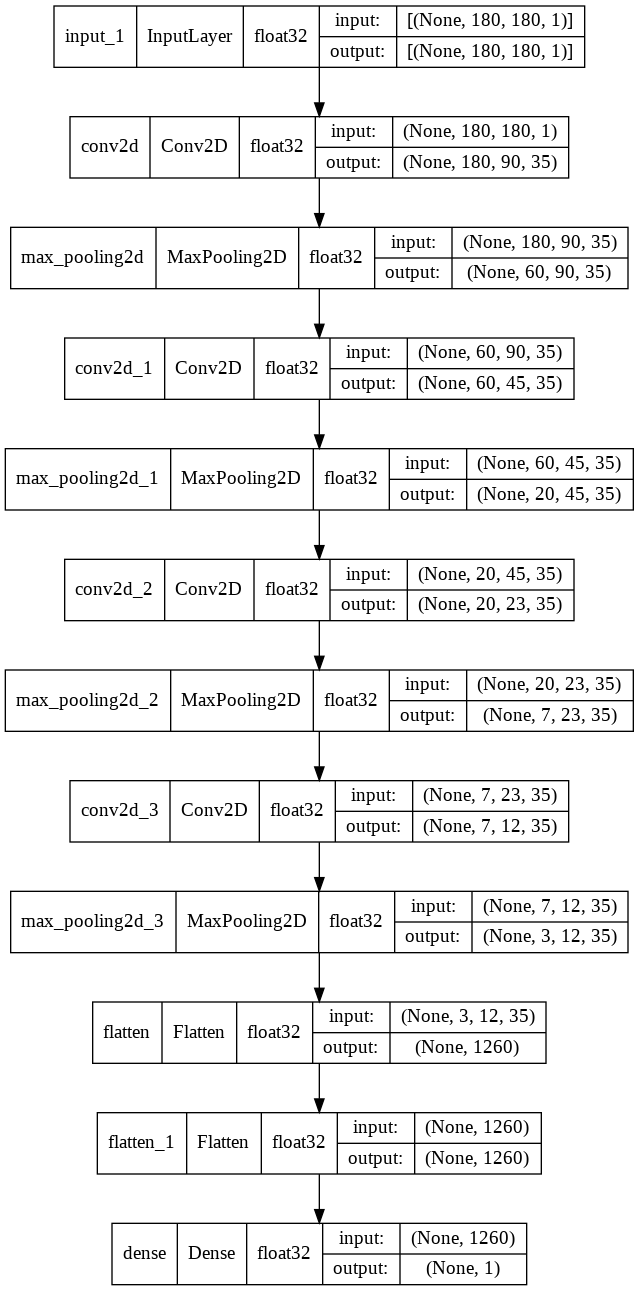

In [ ]:
tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_dtype=True,
                          show_layer_names=True,
                          )

# Train and evaluate

## Re-randomize model weights

In [ ]:
# Get hypertuned model in case
%cd /content/gdrive/My Drive/Colab/plankton/model/
model = tf.keras.models.load_model('tuned_model')

# Check architecture
model.summary()

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab/plankton/model/'
/content/gdrive/My Drive/Colab/plankton/data/tfds_dataset
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 90, 35)       175       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 90, 35)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 45, 35)        4935      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 45, 35)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 23, 

In [ ]:
# Clone and compare weights
original_weights = model.get_weights()
print("Original weights", original_weights[0])
print("========================================================")
print("========================================================")
print("========================================================")
model_cloned = tf.keras.models.clone_model(model)
new_weights = model_cloned.get_weights()
print("New weights", new_weights[0])

Original weights [[[[-0.21269163 -0.14487611 -0.07041718  0.02493937 -0.08547369
    -0.13841236 -0.1809022  -0.12219365 -0.11436173 -0.17776091
    -0.20779623  0.12096602  0.11902867  0.08920687 -0.13485025
    -0.11980651 -0.08462754  0.00924842  0.17634925 -0.1105074
    -0.06698035 -0.03533721  0.14678206 -0.1842028  -0.22743925
     0.1468761   0.12220675  0.13503216 -0.03986374  0.03921294
     0.06456267 -0.13561642 -0.10048465 -0.09705242  0.0528053 ]]

  [[ 0.07008381  0.02802214  0.13479283 -0.07973247  0.12534419
    -0.16157396  0.08182909 -0.1343048   0.0200946   0.02498
     0.06305505  0.1457547  -0.081494    0.14807037  0.16521762
     0.04460944  0.02595965  0.13997214  0.05036449 -0.09160338
     0.03294317  0.17891948  0.02990043  0.03163753  0.18279956
    -0.11720519 -0.0410362   0.0593472   0.01700819 -0.1328602
    -0.13103926  0.07944842 -0.09507338  0.04948742 -0.14550267]]]


 [[[ 0.09408028  0.18463089 -0.06434134  0.08320659 -0.03033
    -0.0396071   0.0274

In [ ]:
print(model.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022454238>


In [ ]:
model_cloned.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=model.optimizer.learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Learning rate for saved model
print(model_cloned.optimizer.learning_rate)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0022454238>


In [ ]:
model = model_cloned
model_weights = model.get_weights()
print(model_weights[0])

[[[[ 0.11630911  0.01179069  0.14415255  0.11196756  0.01550637
    -0.06247814 -0.03082927  0.20368636 -0.13362768  0.07232875
     0.02944124  0.09620696  0.17617032  0.0289789   0.16734499
     0.11228827 -0.17893825 -0.03014146 -0.0885421   0.08749381
    -0.12783757 -0.05736198  0.20147821 -0.15845485 -0.04366213
     0.10487548  0.18527675 -0.18193896  0.02611807  0.06948489
    -0.14637484  0.025518    0.1716564  -0.07805504  0.06904212]]

  [[ 0.07017756  0.00299355 -0.05774878  0.20169318  0.1806804
     0.01050507 -0.15442923 -0.1585387  -0.01310378  0.01580817
     0.1132783  -0.05149692 -0.04192871 -0.04102549  0.0708721
     0.02609324 -0.12325743  0.08586839  0.01827753 -0.11454725
    -0.10623989 -0.09782951 -0.19417112 -0.09360079  0.12455794
    -0.1967221   0.14831772 -0.08525887 -0.08554547  0.11941937
     0.18878913 -0.17614575 -0.15495667  0.06379673 -0.0991312 ]]]


 [[[-0.16459279  0.12118956 -0.19582984 -0.1908129   0.06075212
     0.12725872 -0.07139136 -0.073

In [ ]:
# make sure weights are randomized
test_ds = tfds.load(name='plankton_images_tfds',
                    split='train[90%:100%]',
                    shuffle_files=True,
                    as_supervised=True,
                    read_config=read_config)
test_ds = test_ds.map(preprocess).batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_history = model.evaluate(
    test_ds
)

60/60 [==============================] - 10s 35ms/step - loss: 0.6916 - accuracy: 0.4961


## Training

### loss convergence

In [ ]:
#@title Training hyperparams
k = 10 #@param {type:"slider", min:0, max:100, step:1}
batch = 16 #@param {type:"slider", min:0, max:128, step:1}
epochs =  100000#@param {type:"integer"}

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Record accuracy histories for each fold
acc_histories = []

# Reset model weights
reset_model = lambda model : model.set_weights(model_weights)
reset_model(model)

# Early stopping for convergence
convergence_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-20,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

print('Fold',1)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:81%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[81%:90%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',2)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:72%]+train[81%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[72%:81%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',3)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:63%]+train[72%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[63%:72%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',4)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:54%]+train[63%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[54%:63%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',5)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:45%]+train[54%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[45%:54%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',6)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:36%]+train[45%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[36%:45%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',7)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:27%]+train[36%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[27%:36%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',8)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:18%]+train[27%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[18%:27%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',9)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:9%]+train[18%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[9%:18%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
reset_model(model)
print('\n')
#############################################################################
print('Fold',10)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[9%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[0%:9%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
print('\n')

Fold 1
Epoch 1/100000
964/964 [==============================] - 30s 31ms/step - loss: 0.2125 - accuracy: 0.9145 - val_loss: 0.1245 - val_accuracy: 0.9433
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1520 - accuracy: 0.9402 - val_loss: 0.2611 - val_accuracy: 0.9030
Epoch 3/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1228 - accuracy: 0.9496 - val_loss: 0.1037 - val_accuracy: 0.9585
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1112 - accuracy: 0.9589 - val_loss: 0.1067 - val_accuracy: 0.9579
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0977 - accuracy: 0.9642 - val_loss: 0.1042 - val_accuracy: 0.9591
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1449 - accuracy: 0.9486 - val_loss: 0.1175 - val_accuracy: 0.9562


Fold 2
Epoch 1/100000
964/964 [==============================] - 24s 25ms/step - loss: 0.2201 - accurac

In [ ]:
# redo 10th fold
#@title Training hyperparams
k = 10 #@param {type:"slider", min:0, max:100, step:1}
batch = 16 #@param {type:"slider", min:0, max:128, step:1}
epochs =  100000#@param {type:"integer"}

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Record accuracy histories for each fold
acc_histories = []

# Reset model weights
reset_model = lambda model : model.set_weights(model_weights)
reset_model(model)

# Early stopping for convergence
convergence_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-20,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)
print('Fold',10)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[9%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(16)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[0%:9%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(16)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
print('\n')

Fold 10
Epoch 1/100000
964/964 [==============================] - 28s 28ms/step - loss: 0.2144 - accuracy: 0.9116 - val_loss: 0.1314 - val_accuracy: 0.9398
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1493 - accuracy: 0.9391 - val_loss: 0.1065 - val_accuracy: 0.9650
Epoch 3/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1751 - accuracy: 0.9288 - val_loss: 0.1101 - val_accuracy: 0.9661
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1031 - accuracy: 0.9602 - val_loss: 0.0995 - val_accuracy: 0.9603
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1095 - accuracy: 0.9584 - val_loss: 0.1053 - val_accuracy: 0.9690
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0884 - accuracy: 0.9687 - val_loss: 0.0986 - val_accuracy: 0.9550
Epoch 7/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0842 - accuracy: 0.970

In [ ]:
# Final training before testing
print('Fold',10)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[90%:100%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)

Fold 10
Epoch 1/100000
1071/1071 [==============================] - 27s 25ms/step - loss: 0.1163 - accuracy: 0.9616 - val_loss: 0.1035 - val_accuracy: 0.9601
Epoch 2/100000
1071/1071 [==============================] - 25s 23ms/step - loss: 0.0797 - accuracy: 0.9711 - val_loss: 0.0800 - val_accuracy: 0.9664
Epoch 3/100000
1071/1071 [==============================] - 25s 23ms/step - loss: 0.0722 - accuracy: 0.9739 - val_loss: 0.0762 - val_accuracy: 0.9690
Epoch 4/100000
1071/1071 [==============================] - 25s 23ms/step - loss: 0.1262 - accuracy: 0.9599 - val_loss: 0.0820 - val_accuracy: 0.9695
Epoch 5/100000
1071/1071 [==============================] - 24s 23ms/step - loss: 0.0704 - accuracy: 0.9747 - val_loss: 0.0679 - val_accuracy: 0.9727
Epoch 6/100000
1071/1071 [==============================] - 25s 23ms/step - loss: 0.0788 - accuracy: 0.9721 - val_loss: 0.0751 - val_accuracy: 0.9706
Epoch 7/100000
1071/1071 [==============================] - 24s 23ms/step - loss: 0.0628 - a

In [ ]:
test_ds = tfds.load(name='plankton_images_tfds',
                    split='train[90%:100%]',
                    shuffle_files=True,
                    as_supervised=True,
                    read_config=read_config)
test_ds = test_ds.map(preprocess).batch(batch)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_history = model.evaluate(
    test_ds
)

119/119 [==============================] - 2s 17ms/step - loss: 0.0861 - accuracy: 0.9669


# REDO 10 FOLDS FOR GRAPHS  (RAM OUTAGE)

In [ ]:
import pickle

In [ ]:
#@title Training hyperparams
k = 10 #@param {type:"slider", min:0, max:100, step:1}
batch = 16 #@param {type:"slider", min:0, max:128, step:1}
epochs =  100000#@param {type:"integer"}

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Record accuracy histories for each fold
acc_histories = []

# Reset model weights
reset_model = lambda model : model.set_weights(model_weights)
reset_model(model)

# Early stopping for convergence
convergence_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-20,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

print('Fold',1)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:81%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[81%:90%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',2)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:72%]+train[81%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[72%:81%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',3)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:63%]+train[72%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[63%:72%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',4)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:54%]+train[63%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[54%:63%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',5)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:45%]+train[54%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[45%:54%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',6)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:36%]+train[45%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[36%:45%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',7)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:27%]+train[36%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[27%:36%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',8)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:18%]+train[27%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[18%:27%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',9)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[0%:9%]+train[18%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[9%:18%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
reset_model(model)
print('\n')
#############################################################################
print('Fold',10)
train_ds = tfds.load(name='plankton_images_tfds',
                     split='train[9%:90%]',
                     shuffle_files=True,
                     as_supervised=True,
                     read_config=read_config)
train_ds = train_ds.map(preprocess).batch(batch)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = tfds.load(name='plankton_images_tfds',
                   split='train[0%:9%]',
                   shuffle_files=True,
                   as_supervised=True,
                   read_config=read_config)
val_ds = val_ds.map(preprocess).batch(batch)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
acc_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[convergence_callback],
    validation_data=val_ds,
    #class_weight=class_weight,
)
acc_histories.append(acc_history)
with open('acc_histories.pkl', 'wb') as f:
  pickle.dump(acc_histories, f)
print('\n')

Fold 1
Epoch 1/100000
964/964 [==============================] - 30s 29ms/step - loss: 0.2194 - accuracy: 0.9122 - val_loss: 0.1315 - val_accuracy: 0.9416
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1431 - accuracy: 0.9400 - val_loss: 0.1253 - val_accuracy: 0.9428
Epoch 3/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.1327 - accuracy: 0.9475 - val_loss: 0.1416 - val_accuracy: 0.9381
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1050 - accuracy: 0.9597 - val_loss: 0.1206 - val_accuracy: 0.9579
Epoch 5/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0922 - accuracy: 0.9663 - val_loss: 0.1153 - val_accuracy: 0.9550
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1033 - accuracy: 0.9608 - val_loss: 0.1096 - val_accuracy: 0.9614
Epoch 7/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.1152 - accuracy: 0.9609

INFO:tensorflow:Assets written to: ram://41da7adb-9410-4cbc-bbf2-edbb59492be1/assets




Fold 2
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.2425 - accuracy: 0.8975 - val_loss: 0.1612 - val_accuracy: 0.9357
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1338 - accuracy: 0.9451 - val_loss: 0.1097 - val_accuracy: 0.9609
Epoch 3/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.1109 - accuracy: 0.9570 - val_loss: 0.0938 - val_accuracy: 0.9702
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1080 - accuracy: 0.9603 - val_loss: 0.0905 - val_accuracy: 0.9702
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0907 - accuracy: 0.9668 - val_loss: 0.0828 - val_accuracy: 0.9714
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1059 - accuracy: 0.9610 - val_loss: 0.0810 - val_accuracy: 0.9725
Epoch 7/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0833 - accuracy: 0.96

INFO:tensorflow:Assets written to: ram://a9bc1f33-a8dc-42d3-911a-2c2b1c1babca/assets




Fold 3
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.2179 - accuracy: 0.9042 - val_loss: 0.1379 - val_accuracy: 0.9422
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1206 - accuracy: 0.9522 - val_loss: 0.1242 - val_accuracy: 0.9545
Epoch 3/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1206 - accuracy: 0.9541 - val_loss: 0.2743 - val_accuracy: 0.8628
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0904 - accuracy: 0.9656 - val_loss: 0.1032 - val_accuracy: 0.9621
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0874 - accuracy: 0.9676 - val_loss: 0.1070 - val_accuracy: 0.9650
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0795 - accuracy: 0.9703 - val_loss: 0.1065 - val_accuracy: 0.9632
Epoch 7/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0806 - accuracy: 0.97

INFO:tensorflow:Assets written to: ram://63053421-b706-40fa-afb4-e7d9a65e0a7a/assets




Fold 4
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.2084 - accuracy: 0.9102 - val_loss: 0.1231 - val_accuracy: 0.9416
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1209 - accuracy: 0.9517 - val_loss: 0.0987 - val_accuracy: 0.9650
Epoch 3/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1195 - accuracy: 0.9546 - val_loss: 0.0939 - val_accuracy: 0.9655
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0892 - accuracy: 0.9679 - val_loss: 0.0867 - val_accuracy: 0.9714
Epoch 5/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0858 - accuracy: 0.9685 - val_loss: 0.0868 - val_accuracy: 0.9743
Epoch 6/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0794 - accuracy: 0.9708 - val_loss: 0.0982 - val_accuracy: 0.9655
Epoch 7/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.0763 - accuracy: 0.97

INFO:tensorflow:Assets written to: ram://ec295b1e-b374-4acc-9980-f7d437fc2138/assets




Fold 5
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.2120 - accuracy: 0.9113 - val_loss: 0.1470 - val_accuracy: 0.9375
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1429 - accuracy: 0.9418 - val_loss: 0.1143 - val_accuracy: 0.9544
Epoch 3/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.1756 - accuracy: 0.9316 - val_loss: 0.1143 - val_accuracy: 0.9463
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1228 - accuracy: 0.9538 - val_loss: 0.0945 - val_accuracy: 0.9644
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1069 - accuracy: 0.9607 - val_loss: 0.0886 - val_accuracy: 0.9702
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0956 - accuracy: 0.9663 - val_loss: 0.0763 - val_accuracy: 0.9708
Epoch 7/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0851 - accuracy: 0.96

INFO:tensorflow:Assets written to: ram://6d0a0a8e-9665-4d44-9c46-c49d3559bc6d/assets




Fold 6
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.2057 - accuracy: 0.9168 - val_loss: 0.1436 - val_accuracy: 0.9370
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1423 - accuracy: 0.9411 - val_loss: 0.1177 - val_accuracy: 0.9556
Epoch 3/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1141 - accuracy: 0.9544 - val_loss: 0.1093 - val_accuracy: 0.9621
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1046 - accuracy: 0.9596 - val_loss: 0.0982 - val_accuracy: 0.9656
Epoch 5/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0977 - accuracy: 0.9623 - val_loss: 0.0962 - val_accuracy: 0.9621
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0958 - accuracy: 0.9637 - val_loss: 0.0865 - val_accuracy: 0.9679
Epoch 7/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0995 - accuracy: 0.96

INFO:tensorflow:Assets written to: ram://6ed58041-45bd-49ab-9cb7-4abcd386aa47/assets




Fold 7
Epoch 1/100000
964/964 [==============================] - 25s 26ms/step - loss: 0.1996 - accuracy: 0.9162 - val_loss: 0.1252 - val_accuracy: 0.9521
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1174 - accuracy: 0.9543 - val_loss: 0.0994 - val_accuracy: 0.9638
Epoch 3/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1066 - accuracy: 0.9586 - val_loss: 0.0941 - val_accuracy: 0.9626
Epoch 4/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0893 - accuracy: 0.9669 - val_loss: 0.0899 - val_accuracy: 0.9620
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0871 - accuracy: 0.9688 - val_loss: 0.0965 - val_accuracy: 0.9638
Epoch 6/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0845 - accuracy: 0.9686 - val_loss: 0.0953 - val_accuracy: 0.9626
Epoch 7/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.0865 - accuracy: 0.96

INFO:tensorflow:Assets written to: ram://6807172a-4165-4462-80b7-371e93b56d83/assets




Fold 8
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.1950 - accuracy: 0.9188 - val_loss: 0.1167 - val_accuracy: 0.9533
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1166 - accuracy: 0.9524 - val_loss: 0.1086 - val_accuracy: 0.9620
Epoch 3/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0943 - accuracy: 0.9659 - val_loss: 0.0961 - val_accuracy: 0.9644
Epoch 4/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.1497 - accuracy: 0.9422 - val_loss: 0.1211 - val_accuracy: 0.9498
Epoch 5/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1004 - accuracy: 0.9613 - val_loss: 0.0965 - val_accuracy: 0.9685
Epoch 6/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0832 - accuracy: 0.9688 - val_loss: 0.0895 - val_accuracy: 0.9720
Epoch 7/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.0855 - accuracy: 0.96

INFO:tensorflow:Assets written to: ram://4411ed7a-331b-4538-9de2-46c534f15cc8/assets




Fold 9
Epoch 1/100000
964/964 [==============================] - 26s 27ms/step - loss: 0.1919 - accuracy: 0.9210 - val_loss: 0.0949 - val_accuracy: 0.9691
Epoch 2/100000
964/964 [==============================] - 22s 23ms/step - loss: 0.1010 - accuracy: 0.9626 - val_loss: 0.0775 - val_accuracy: 0.9731
Epoch 3/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.2063 - accuracy: 0.9158 - val_loss: 0.0991 - val_accuracy: 0.9661
Epoch 4/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.1086 - accuracy: 0.9580 - val_loss: 0.0810 - val_accuracy: 0.9720
Epoch 5/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.0943 - accuracy: 0.9652 - val_loss: 0.0752 - val_accuracy: 0.9737
Epoch 6/100000
964/964 [==============================] - 23s 23ms/step - loss: 0.0878 - accuracy: 0.9687 - val_loss: 0.0752 - val_accuracy: 0.9720
Epoch 7/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.0852 - accuracy: 0.96

INFO:tensorflow:Assets written to: ram://3df3dff4-d670-4fee-9676-263b882c6c76/assets




Fold 10
Epoch 1/100000
964/964 [==============================] - 27s 28ms/step - loss: 0.2051 - accuracy: 0.9118 - val_loss: 0.1258 - val_accuracy: 0.9387
Epoch 2/100000
964/964 [==============================] - 24s 25ms/step - loss: 0.1292 - accuracy: 0.9441 - val_loss: 0.1039 - val_accuracy: 0.9632
Epoch 3/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.1875 - accuracy: 0.9251 - val_loss: 0.1070 - val_accuracy: 0.9644
Epoch 4/100000
964/964 [==============================] - 24s 25ms/step - loss: 0.1033 - accuracy: 0.9604 - val_loss: 0.0956 - val_accuracy: 0.9685
Epoch 5/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.0909 - accuracy: 0.9662 - val_loss: 0.0930 - val_accuracy: 0.9638
Epoch 6/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.0865 - accuracy: 0.9676 - val_loss: 0.0924 - val_accuracy: 0.9626
Epoch 7/100000
964/964 [==============================] - 23s 24ms/step - loss: 0.1654 - accuracy: 0.9

INFO:tensorflow:Assets written to: ram://818377e0-ff32-4d3f-b0e3-c25d3fe1ae45/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


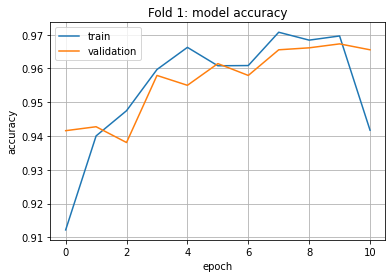

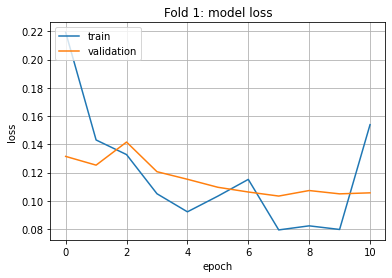

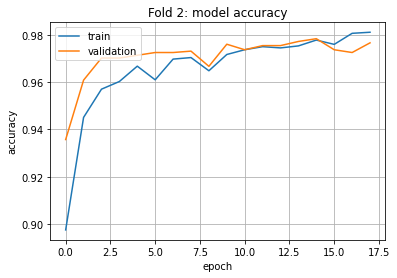

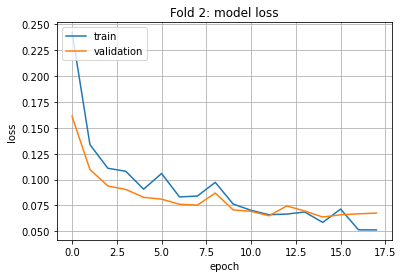

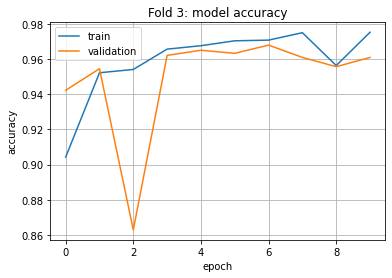

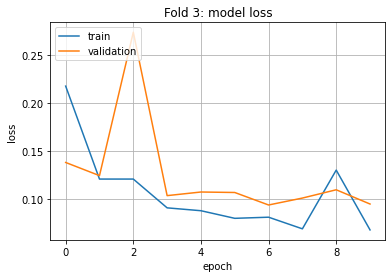

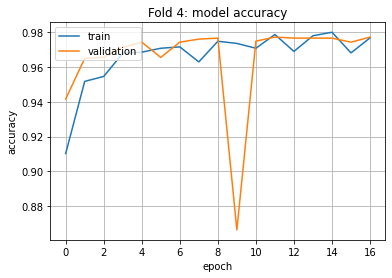

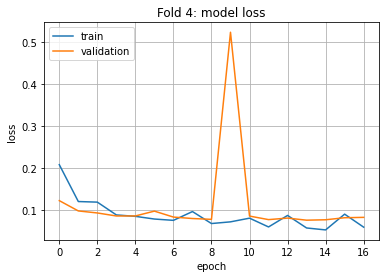

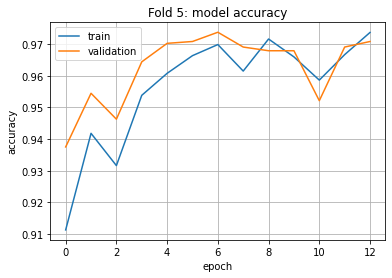

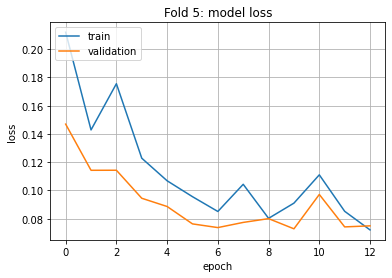

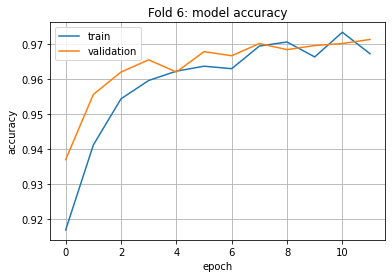

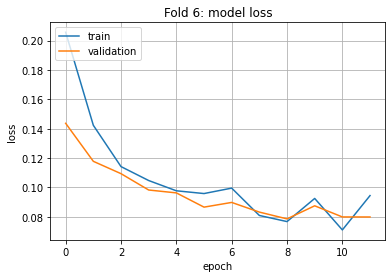

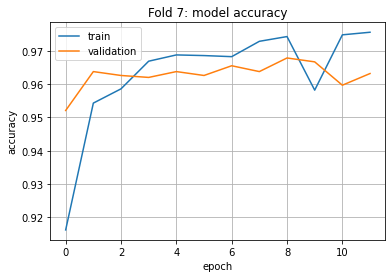

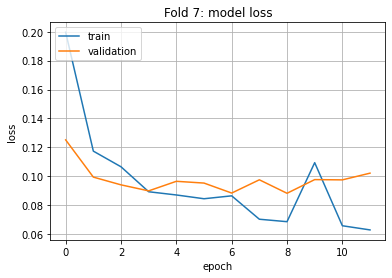

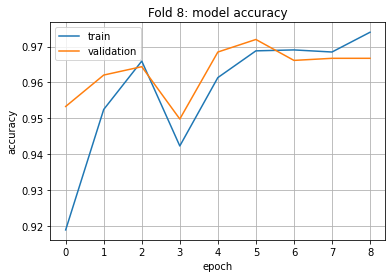

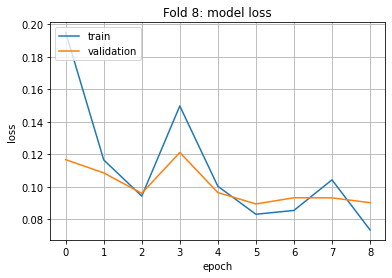

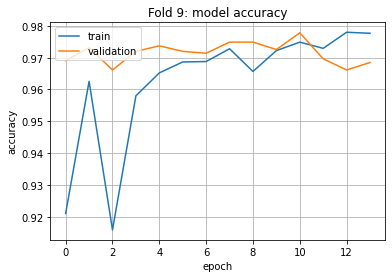

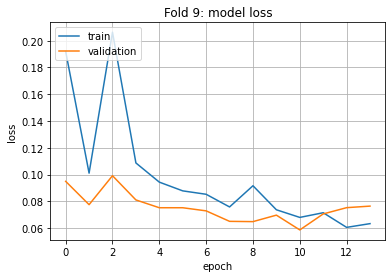

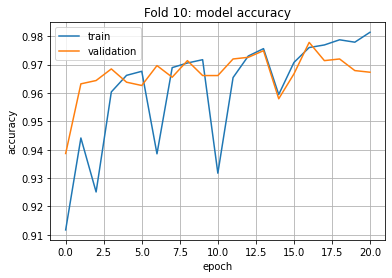

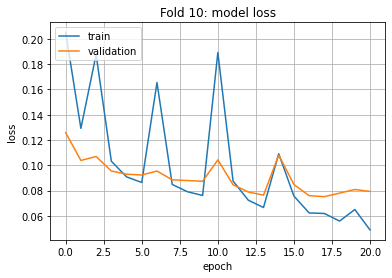

In [ ]:
# list all data in history
for acc_history in acc_histories:
  print(acc_history.history.keys())

fold_num = 1
for acc_history in acc_histories:
  # summarize history for accuracy
  plt.plot(acc_history.history['accuracy'])
  plt.plot(acc_history.history['val_accuracy'])
  title = 'Fold ' + str(fold_num) + ': model accuracy'
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.show()
  # summarize history for loss
  plt.plot(acc_history.history['loss'])
  plt.plot(acc_history.history['val_loss'])
  title = 'Fold ' + str(fold_num) + ': model loss'
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.show()
  fold_num += 1

In [ ]:
with open('acc_histories.pkl', 'rb') as f:
  acc = pickle.load(f)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


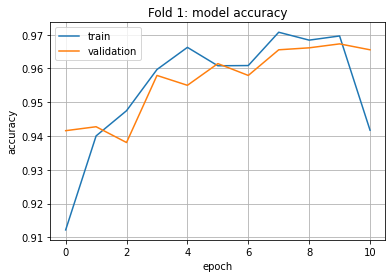

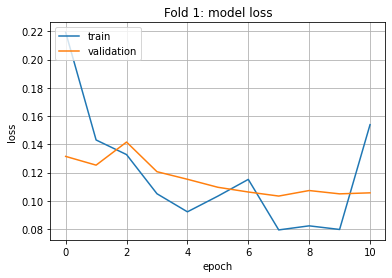

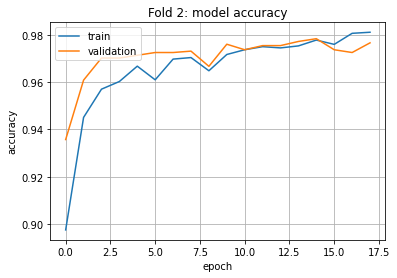

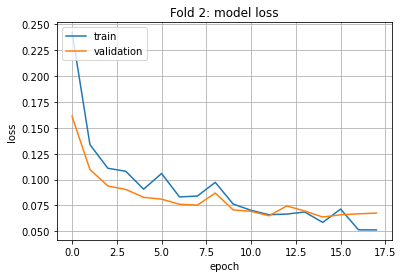

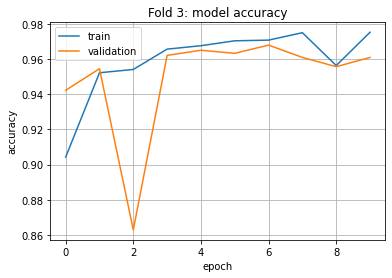

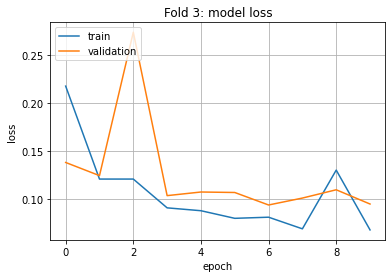

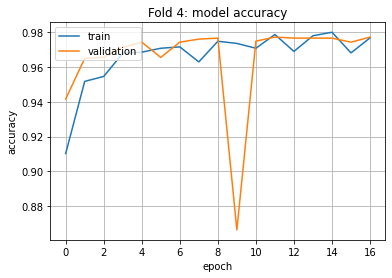

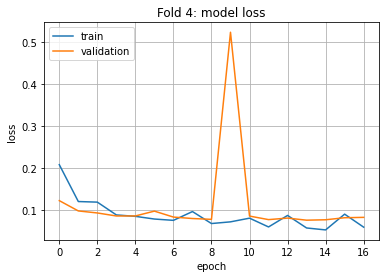

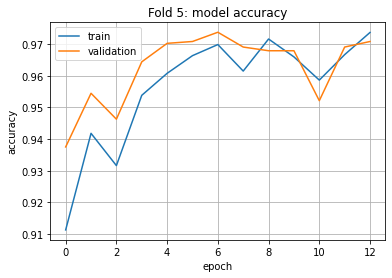

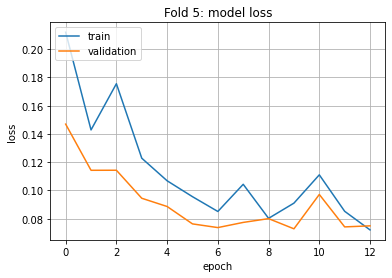

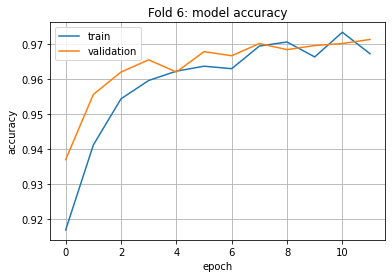

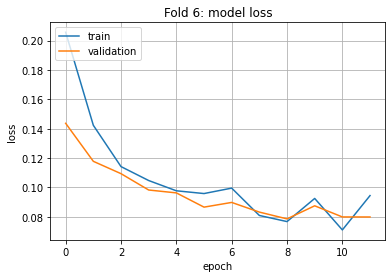

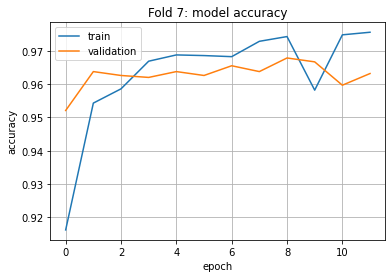

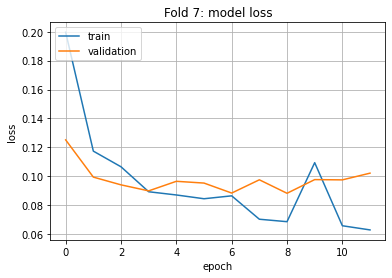

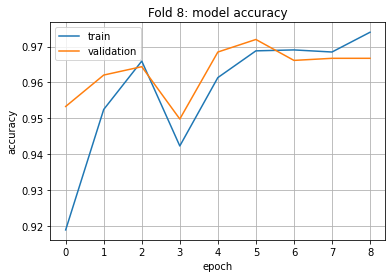

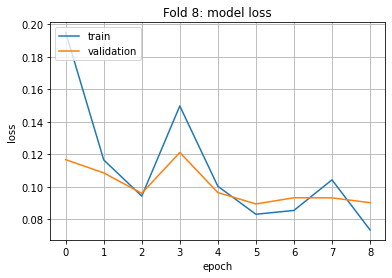

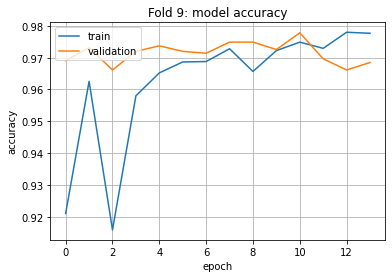

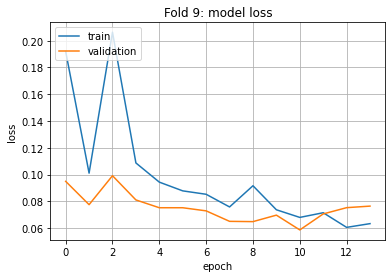

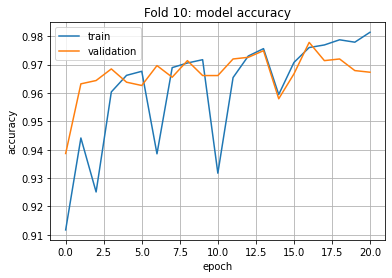

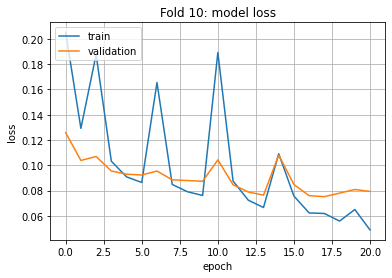

In [ ]:
# list all data in history
for acc in acc_histories:
  print(acc.history.keys())

fold_num = 1
for acc in acc_histories:
  # summarize history for accuracy
  plt.plot(acc.history['accuracy'])
  plt.plot(acc.history['val_accuracy'])
  title = 'Fold ' + str(fold_num) + ': model accuracy'
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.show()
  # summarize history for loss
  plt.plot(acc.history['loss'])
  plt.plot(acc.history['val_loss'])
  title = 'Fold ' + str(fold_num) + ': model loss'
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.show()
  fold_num += 1